In [1]:
import pandas as pd
import numpy as np
from plotnine import *

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

data_full = fetch_openml(
    "titanic", version=1, as_frame=True
)

data = pd.concat([data_full['data'], data_full['target']], axis = 1)

drop_cols = ['boat', 'body', 'home.dest']

data.drop(columns = drop_cols, inplace = True)

# change data types to match the csv data types in kaggle
data = data.astype({'pclass': 'int32', 'sex': 'object', 'sibsp': 'int32', 'parch': 'int32', 'fare': 'float32', 'embarked': 'object', 'survived': 'int32'})
data.head()

/Users/sidbasu/opt/anaconda3/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.


,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,survived
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.337494,B5,S,1
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.550003,C22 C26,S,1
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.550003,C22 C26,S,0
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.550003,C22 C26,S,0
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.550003,C22 C26,S,0


# Feature Engineering

In [3]:
def feature_engineering(df):
    # construct cabin and deck features
    df['deck_raw'] = df['cabin'].str[0]
    df['deck_raw'] = df['deck_raw'].fillna('M')
    df['cabin_no'] = df['cabin'].str.split('(\d+)', expand = True)[1].fillna(0).astype(int)

    df['deck'] = df['deck_raw'].replace(['A', 'T'], 'A')
    df['deck'] = df['deck'].replace(['F', 'G'], 'FG')

    #construct title features, combine titles
    df['title'] = df['name'].str.split(",", expand = True)[1].str.split('.', expand = True)[0].str.strip()

    df['title'] = df['title'].replace(['Ms'], 'Miss')
    noble_list = ['Dr', 'Rev', 'Mlle', 'Major', 'Col', 'the Countess', 'Capt', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer', 'Dona']

    df['title'] = df['title'].replace(noble_list, 'Noble')

    
    df['married'] = 0
    df.loc[df['title'] == 'Mrs', 'married'] = 1

    return(df)


data = feature_engineering(data)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int32  
 1   name      1309 non-null   object 
 2   sex       1309 non-null   object 
 3   age       1046 non-null   float64
 4   sibsp     1309 non-null   int32  
 5   parch     1309 non-null   int32  
 6   ticket    1309 non-null   object 
 7   fare      1308 non-null   float32
 8   cabin     295 non-null    object 
 9   embarked  1307 non-null   object 
 10  survived  1309 non-null   int32  
 11  deck_raw  1309 non-null   object 
 12  cabin_no  1309 non-null   int64  
 13  deck      1309 non-null   object 
 14  title     1309 non-null   object 
 15  married   1309 non-null   int64  
dtypes: float32(1), float64(1), int32(4), int64(2), object(8)
memory usage: 138.2+ KB


## Deck distribution and analysis

In [5]:
# (
#     data
#     .assign(deck = data['cabin'].str[0].fillna('M'),
#             cabin_no = data['cabin'].str.split('(\d+)', expand = True)[1].fillna(0).astype(int))
#     .head(1)
# )

In [6]:
survival_deck = (
    data
    .groupby('deck_raw')
    .agg(n = ('sibsp', 'count'),
         pct_survived = ('survived', 'mean'))
    .reset_index()
)

survival_deck

,deck_raw,n,pct_survived
0,A,22,0.500000
1,B,65,0.723077
2,C,94,0.606383
3,D,46,0.695652
4,E,41,0.731707
5,F,21,0.619048
6,G,5,0.600000
7,M,1014,0.302761
8,T,1,0.000000


In [7]:
#df_all['deck'] = df_all['deck'].replace(['A', 'B', 'C'], 'ABC')
data['deck'].value_counts()

deck
M     1014
C       94
B       65
D       46
E       41
FG      26
A       23
Name: count, dtype: int64

## Title distribution and analysis

In [8]:
data['title'].value_counts()

title
Mr        757
Miss      262
Mrs       197
Master     61
Noble      32
Name: count, dtype: int64

In [9]:
survival_title = (
    data
    .groupby('title')
    .agg(n = ('name', 'count'),
         avg_survival = ('survived', 'mean'))
    .reset_index()
)

survival_title

,title,n,avg_survival
0,Master,61,0.508197
1,Miss,262,0.675573
2,Mr,757,0.162483
3,Mrs,197,0.786802
4,Noble,32,0.437500


# Train a model on full training data

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer, SimpleImputer
import xgboost as xgb
from sklearn import set_config

# Initial setup for classification, setting up train/test splits etc
set_config(transform_output="pandas")

target = 'survived'
numeric_cols = ['sibsp', 'parch', 'fare', 'age']
categorical_cols = ['pclass', 'sex', 'embarked', 'deck', 'title']

X, y = data[numeric_cols + categorical_cols].copy(), np.asarray(data[target], dtype = 'int8')

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, random_state = 20230507)

skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 20230301)

# Pipeline steps for preprocessing data (encode categoricals, impute nulls, discretize / scale numerics) 

ct_encode = ColumnTransformer([
#    ('scaler', StandardScaler(), numeric_cols), #if just this line, the pipeline will only return the four numeric columns, scaled
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ('pass_through_numerics', 'passthrough', numeric_cols)
])

# option 1, discretize the data
ct_disc = ColumnTransformer(
    transformers = [('disc_age', KBinsDiscretizer(n_bins = 10, encode = 'ordinal'), ['pass_through_numerics__age']),
                    ('disc_fare', KBinsDiscretizer(n_bins = 15, encode = 'ordinal'), ['pass_through_numerics__fare']),
                    ],
    remainder = 'passthrough'
)

# option 2, use a standard scaler
ct_scale = ColumnTransformer(
    transformers = [('scale', StandardScaler(), ['pass_through_numerics__age', 'pass_through_numerics__fare'])],
    remainder = 'passthrough'
)

xgb_model = xgb.XGBClassifier(eval_metric = 'logloss')

pipe = Pipeline([
    ('encode_cats', ct_encode),
    ('scale', ct_scale),
    ('imputer', IterativeImputer()),
#    ('disc', ct_disc),
    ('clf', xgb_model),
])

pipe.fit(X_train_full, y_train_full)

Pipeline(steps=[('encode_cats',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['pclass', 'sex', 'embarked',
                                                   'deck', 'title']),
                                                 ('pass_through_numerics',
                                                  'passthrough',
                                                  ['sibsp', 'parch', 'fare',
                                                   'age'])])),
                ('scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale', StandardScaler(),
                                                  ['pass_t...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [11]:
from sklearn.metrics import classification_report

y_pred = pipe.predict(X_test)
y_pred_proba = pipe.predict_proba(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       210
           1       0.70      0.72      0.71       118

    accuracy                           0.79       328
   macro avg       0.77      0.77      0.77       328
weighted avg       0.79      0.79      0.79       328



In [12]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred_proba[:,1])

0.8438861985472155

# Hyperparameter Optimization

## Using Bayessearch CV

In [13]:
%%time

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

np.int = np.int64

search_spaces = {
        'clf__colsample_bytree': Real(0.1, 0.9, 'uniform'), 
        'clf__gamma': Real(0, 1),
        'clf__learning_rate': Real(0.1, 1.0, 'log-uniform'), 
        'clf__max_depth': (1, 10), 
        'clf__min_child_weight': (3, 50), 
        'clf__n_estimators': (50, 1000),
        'clf__reg_lambda': Real(1e-9, 1000, 'log-uniform'), 
        'clf__reg_alpha': Real(1, 100, 'log-uniform'),
        'clf__subsample': Real(0.01, 0.9, 'uniform'),
    }

cv_results_dict = {}

seeds = [20230101, 20221001, 20230620]

for i, seed in enumerate(seeds):
    
    bayes_cv = BayesSearchCV(
        estimator = pipe,
        search_spaces = search_spaces,
        scoring = 'average_precision',
        cv = skf,
        n_jobs = -1,
        # n_points = 9,
        n_iter = 50,
        verbose = 0,
        refit = True,
        random_state = seed
    )

    cv_results_dict[i] = bayes_cv.fit(X_train_full, y_train_full)

CPU times: user 12min 16s, sys: 3min 4s, total: 15min 20s
Wall time: 5min 19s


In [14]:
#seems to be num hyperparameters * num_iter
bayes_cv.total_iterations

450

In [15]:
# bayes_cv.best_params_

dict_optimal_parameters = {}
for param in search_spaces.keys():
    dict_optimal_parameters[param] = []
    for i in cv_results_dict:
        dict_optimal_parameters[param].append(cv_results_dict[i].best_params_[param])

df_optimal_params = pd.DataFrame(dict_optimal_parameters)
df_optimal_params

,clf__colsample_bytree,clf__gamma,clf__learning_rate,clf__max_depth,clf__min_child_weight,clf__n_estimators,clf__reg_lambda,clf__reg_alpha,clf__subsample
0,0.9,0.0,0.243598,10,3,111,1.000000e-09,4.976492,0.793112
1,0.1,0.0,0.100000,10,3,1000,1.000000e-09,1.000000,0.696005
2,0.9,0.0,0.800573,10,3,559,1.000000e+03,4.293150,0.718744


In [16]:
train_set_metrics = []

for i in cv_results_dict:
    train_set_metrics.append(cv_results_dict[i].best_score_)

train_set_metrics

[0.8367353371504773, 0.839318167195521, 0.8337348089226359]

In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

df_compare_preds = X_test.copy()
df_compare_preds['y_test'] = y_test

for i in cv_results_dict:

    fitted_best_estimator = cv_results_dict[i].best_estimator_.fit(X_train_full, y_train_full)
    y_pred = fitted_best_estimator.predict(X_test)
    y_pred_proba = fitted_best_estimator.predict_proba(X_test)[:,1]

    df_compare_preds[f"y_pred_{i}"] = y_pred
    df_compare_preds[f"y_pred_proba_{i}"] = y_pred_proba

    print(classification_report(y_test, y_pred))
    print(f"Best test set AUC: {roc_auc_score(y_test, y_pred_proba)}")

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       210
           1       0.75      0.72      0.74       118

    accuracy                           0.81       328
   macro avg       0.80      0.79      0.80       328
weighted avg       0.81      0.81      0.81       328

Best test set AUC: 0.8628329297820824
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       210
           1       0.75      0.72      0.73       118

    accuracy                           0.81       328
   macro avg       0.80      0.79      0.79       328
weighted avg       0.81      0.81      0.81       328

Best test set AUC: 0.8622679580306699
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       210
           1       0.72      0.71      0.72       118

    accuracy                           0.80       328
   macro avg       0.78      0.78      0.78       32

In [18]:
def find_disagreement(index_1, index_2):
    return(df_compare_preds[df_compare_preds[f"y_pred_{index_1}"] != df_compare_preds[f"y_pred_{index_2}"]])
           
find_disagreement(0, 1)

,sibsp,parch,fare,age,pclass,sex,embarked,deck,title,y_test,y_pred_0,y_pred_proba_0,y_pred_1,y_pred_proba_1,y_pred_2,y_pred_proba_2
225,0,0,93.500000,23.0000,1,male,S,B,Mr,0,0,0.383366,1,0.502339,0,0.492754
1273,2,0,18.000000,18.0000,3,female,S,M,Miss,0,0,0.491473,1,0.569378,1,0.544409
726,0,0,7.629200,30.0000,3,female,Q,M,Miss,0,0,0.458097,1,0.544085,1,0.617540
427,1,1,14.500000,0.6667,2,male,S,M,Master,1,1,0.622615,0,0.309119,1,0.718338
899,0,2,11.133300,27.0000,3,female,S,M,Mrs,1,0,0.443465,1,0.577218,0,0.487985
294,1,1,110.883301,49.0000,1,male,C,C,Mr,0,0,0.352273,1,0.564430,0,0.404378
1305,1,0,14.454200,NaN,3,female,C,M,Miss,0,1,0.606380,0,0.378411,1,0.699596
805,0,0,56.495800,NaN,3,male,S,M,Mr,1,0,0.376712,1,0.513613,0,0.163892
692,0,0,7.283300,18.5000,3,female,Q,M,Miss,0,1,0.619150,0,0.308346,1,0.594035
545,3,0,21.000000,30.0000,2,female,S,M,Mrs,1,1,0.646943,0,0.297286,1,0.604566


About 5% (15 of 300) of the model predictions vary between model version on the test set

In [19]:
# from skopt import dump, load

# dump(bayes_cv, 'bayes_cv.pkl')
# 
# if bayes_cv is None:
#     bayes_cv = load('bayes_cv.pkl')

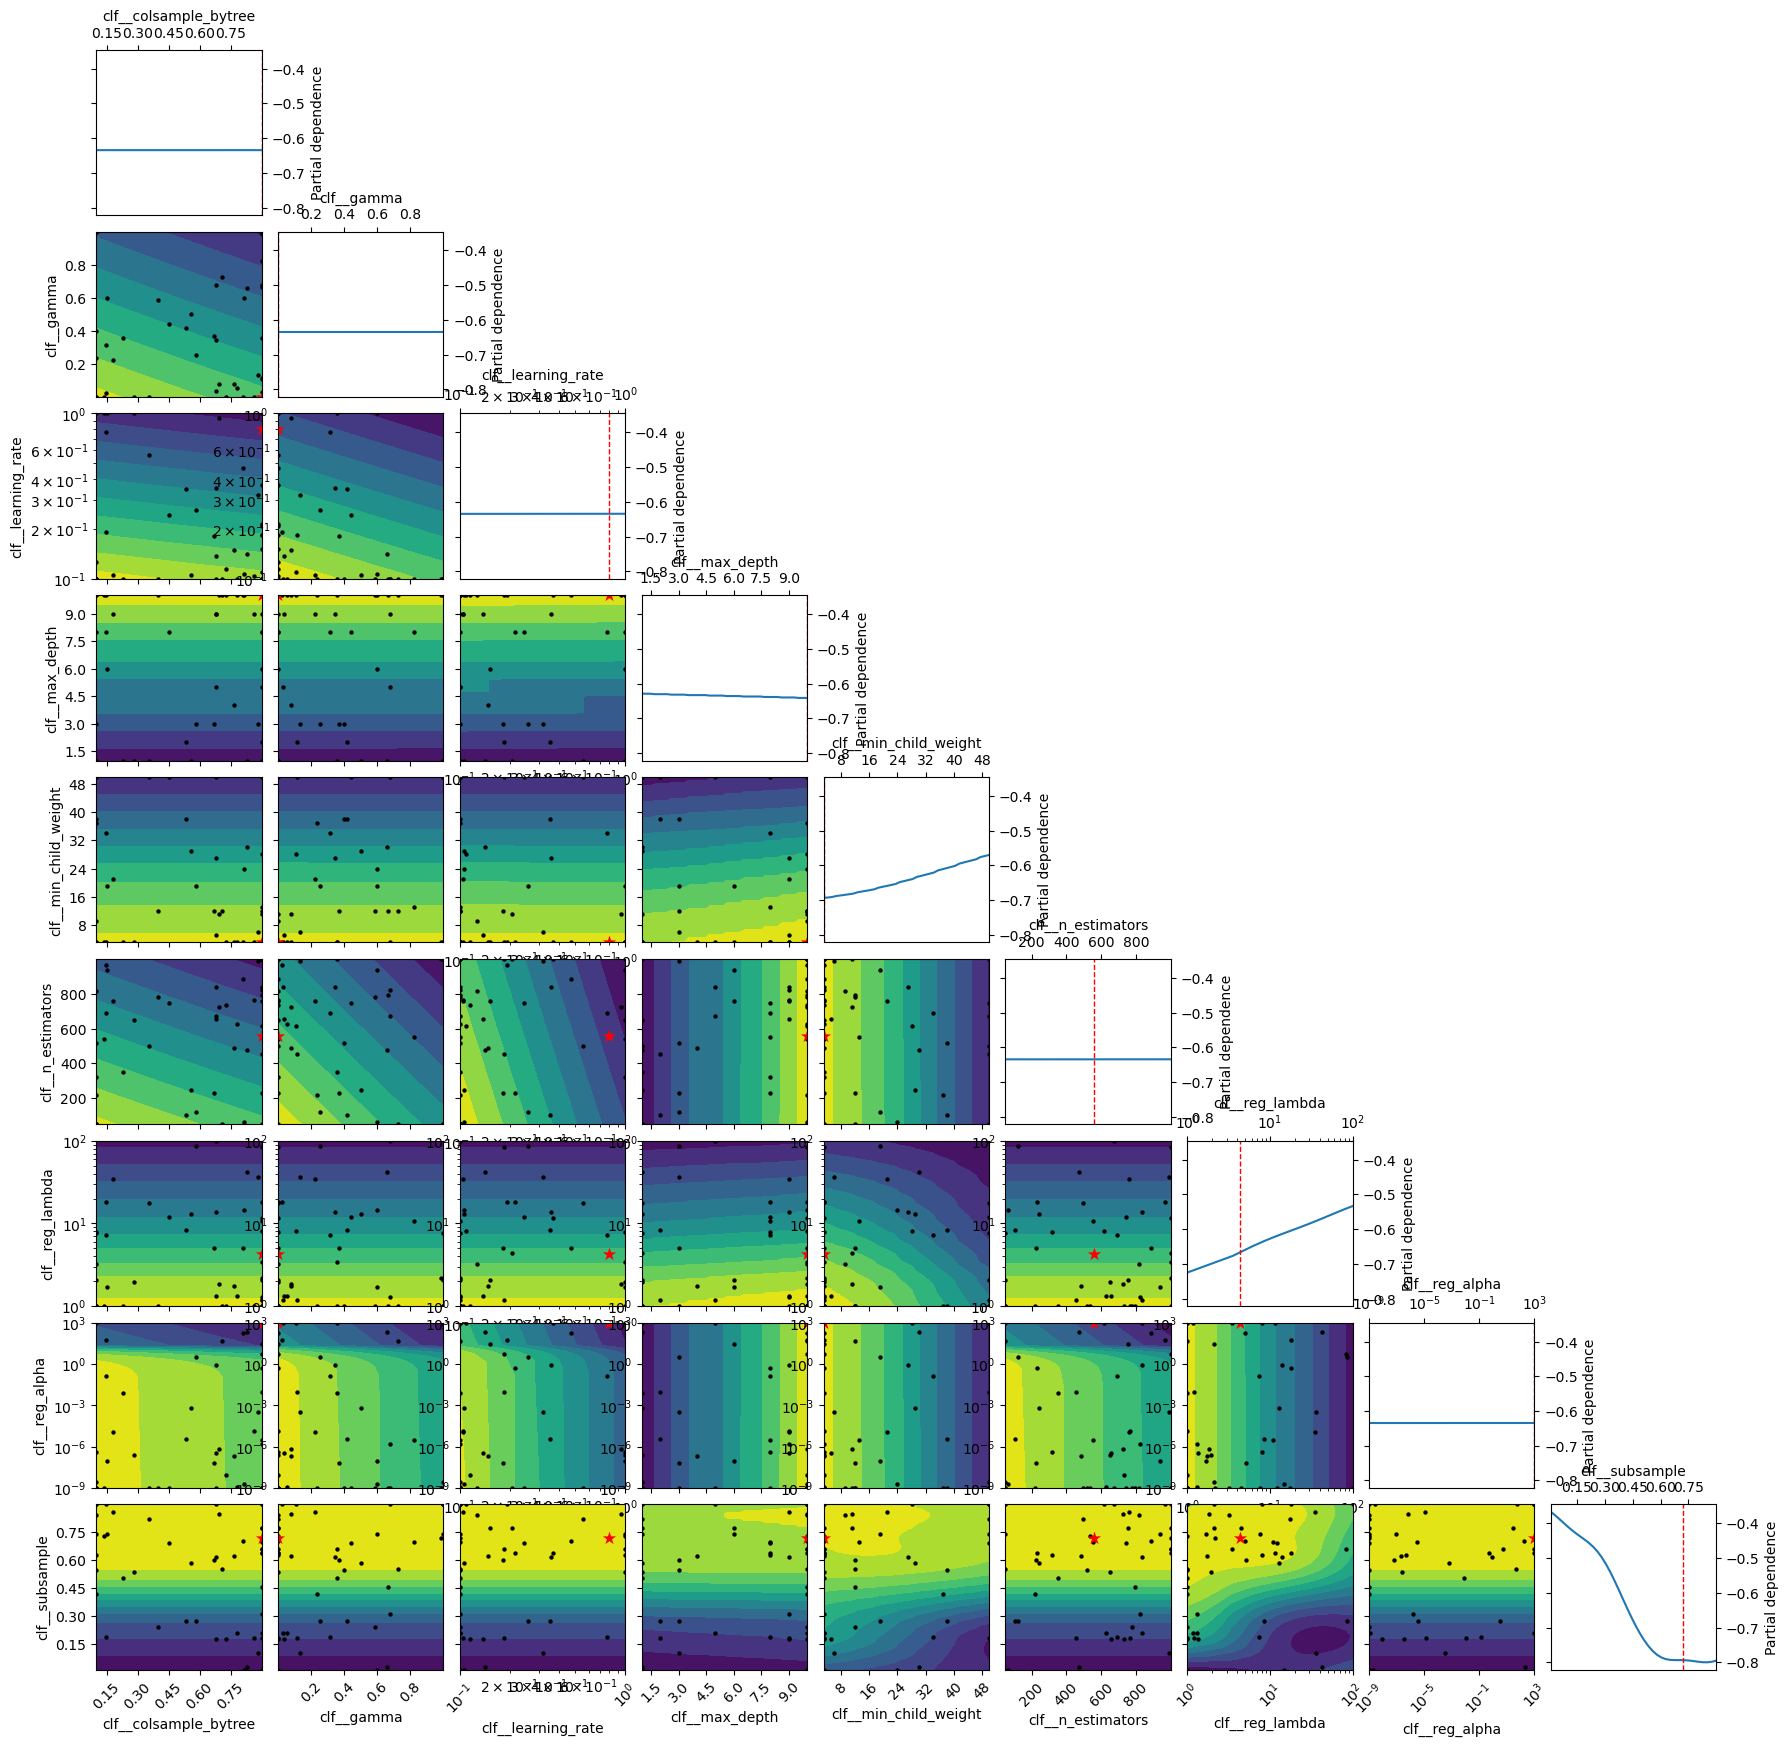

In [20]:
from skopt.plots import plot_objective, plot_histogram
import matplotlib.pyplot as plt

_ = plot_objective(bayes_cv.optimizer_results_[0],
                   dimensions=list(search_spaces.keys()),
                   n_minimum_search=int(1e8))
plt.show()


## Best model evaluation

Find the threshold that maximizes F1 score on the test set

Best test set AUC: 0.8628329297820824
The max F1 score for the model is 0.742
The threshold that achieves this is 0.521


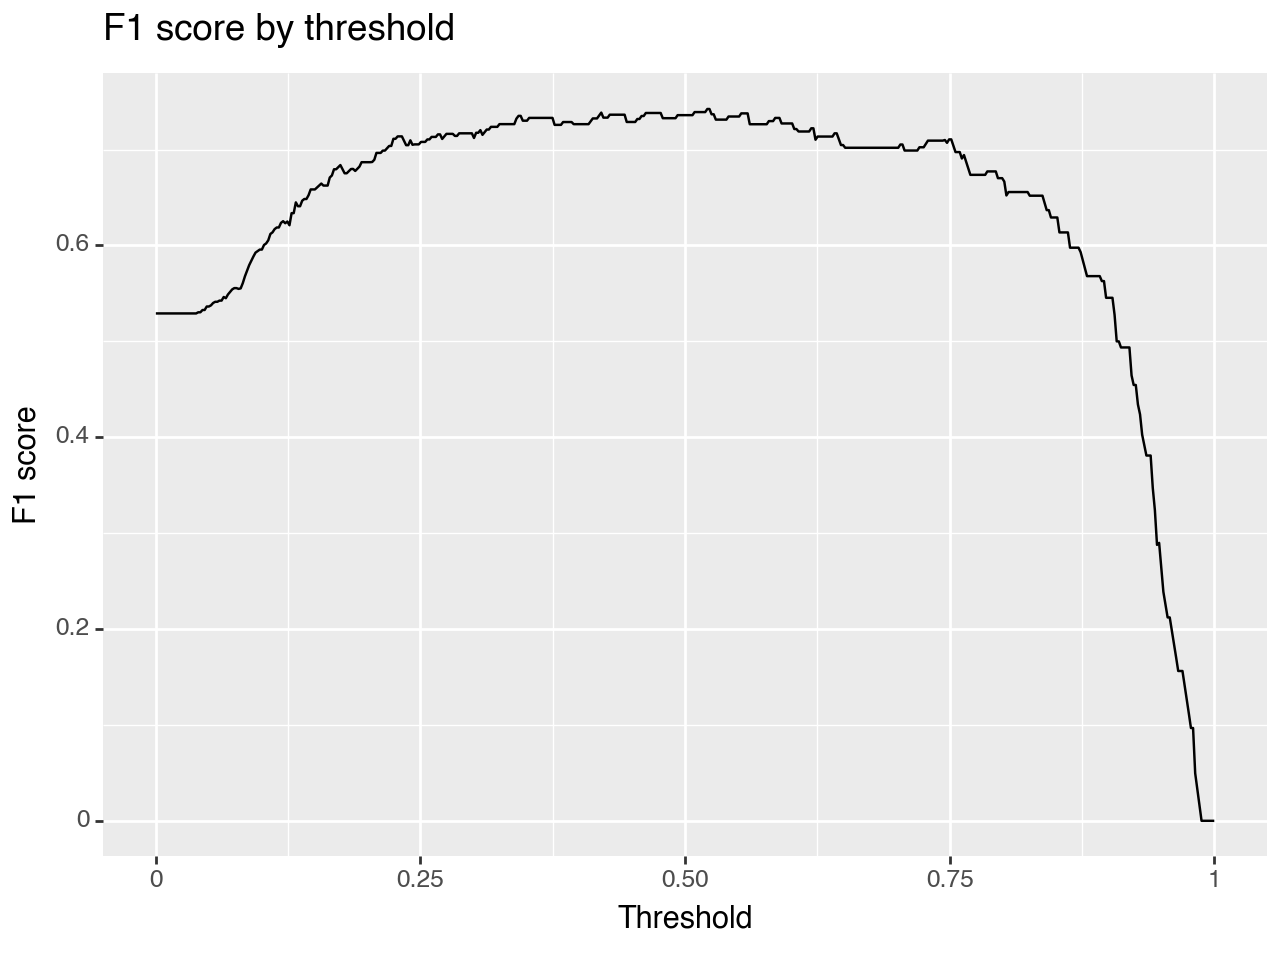

<Figure Size: (640 x 480)>

In [21]:
from sklearn.metrics import roc_auc_score, f1_score
from plotnine import *

#remember to pass the index of the best estimator
fitted_best_estimator = cv_results_dict[0].best_estimator_.fit(X_train_full, y_train_full)
y_pred = fitted_best_estimator.predict(X_test)
y_pred_proba = fitted_best_estimator.predict_proba(X_test)[:,1]

print(f"Best test set AUC: {roc_auc_score(y_test, y_pred_proba)}")

def f1_score_threshold(threshold, y, y_true):
    y_pred_class = y > threshold
    return(f1_score(y_true, y_pred_class))

def plot_f1_score(y, y_true):
    x_grid = np.linspace(0, 1, 500)
    y_grid = np.array([f1_score_threshold(x, y, y_true) for x in x_grid])

    max_score = np.max(y_grid)
    print(f"The max F1 score for the model is {round(max_score, 3)}")
    best_threshold = x_grid[np.argmax(y_grid)]
    print(f"The threshold that achieves this is {round(best_threshold, 3)}")

    df = pd.DataFrame({"x": x_grid, "y": y_grid})
    plt = (
        ggplot(df, aes(x = 'x', y = 'y'))
        + geom_line()
        + xlab("Threshold")
        + ylab("F1 score")
        + ggtitle("F1 score by threshold")
    )
    return(plt)

plot_f1_score(y_pred_proba, y_test)


Precision-recall and ROC curves

In [22]:
from model_diagnostics import model_diagnostics

[scores, cm, plots] = model_diagnostics(y_test, y_pred_proba, y_pred)

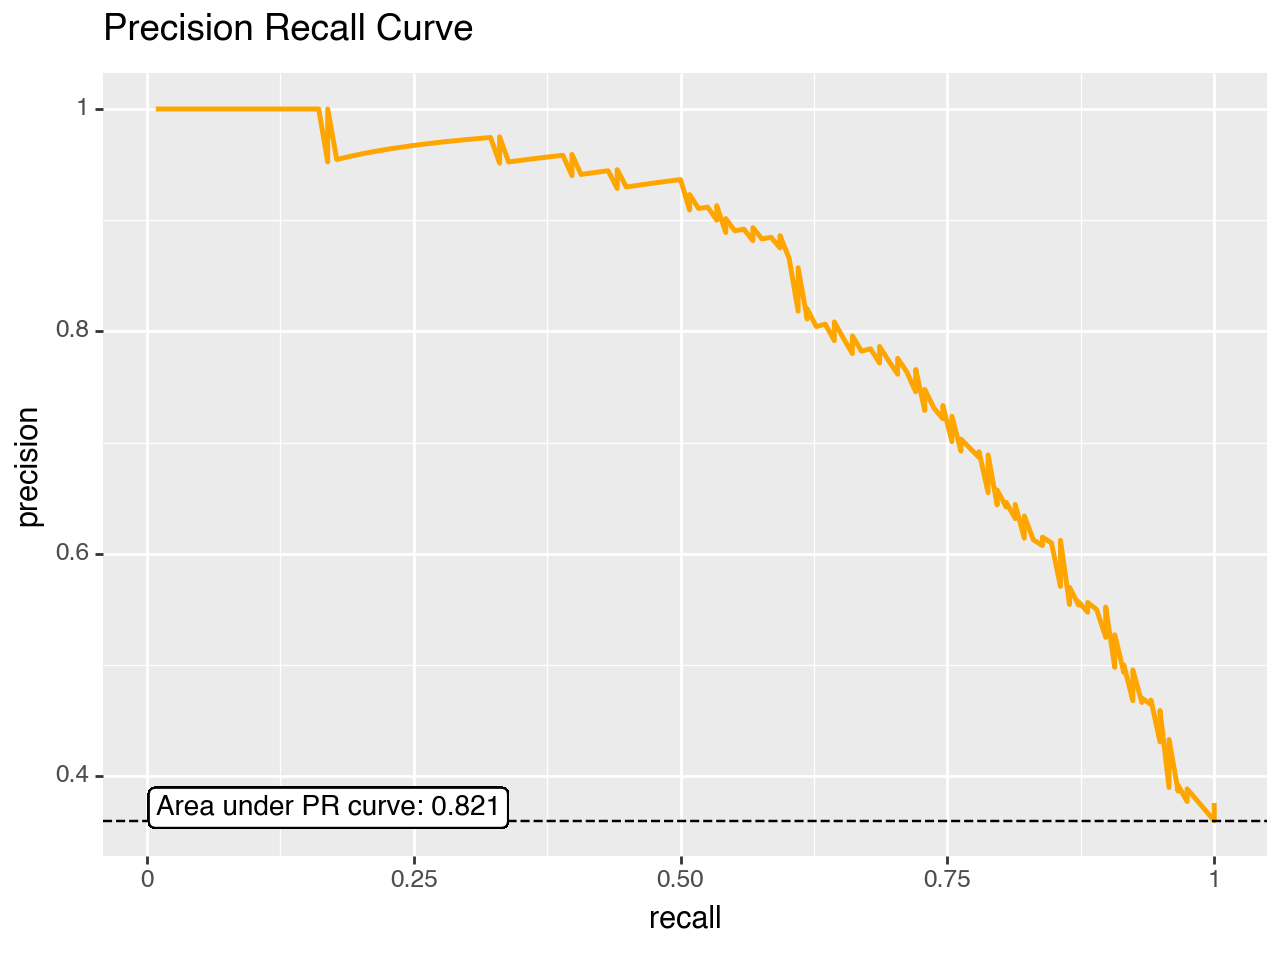

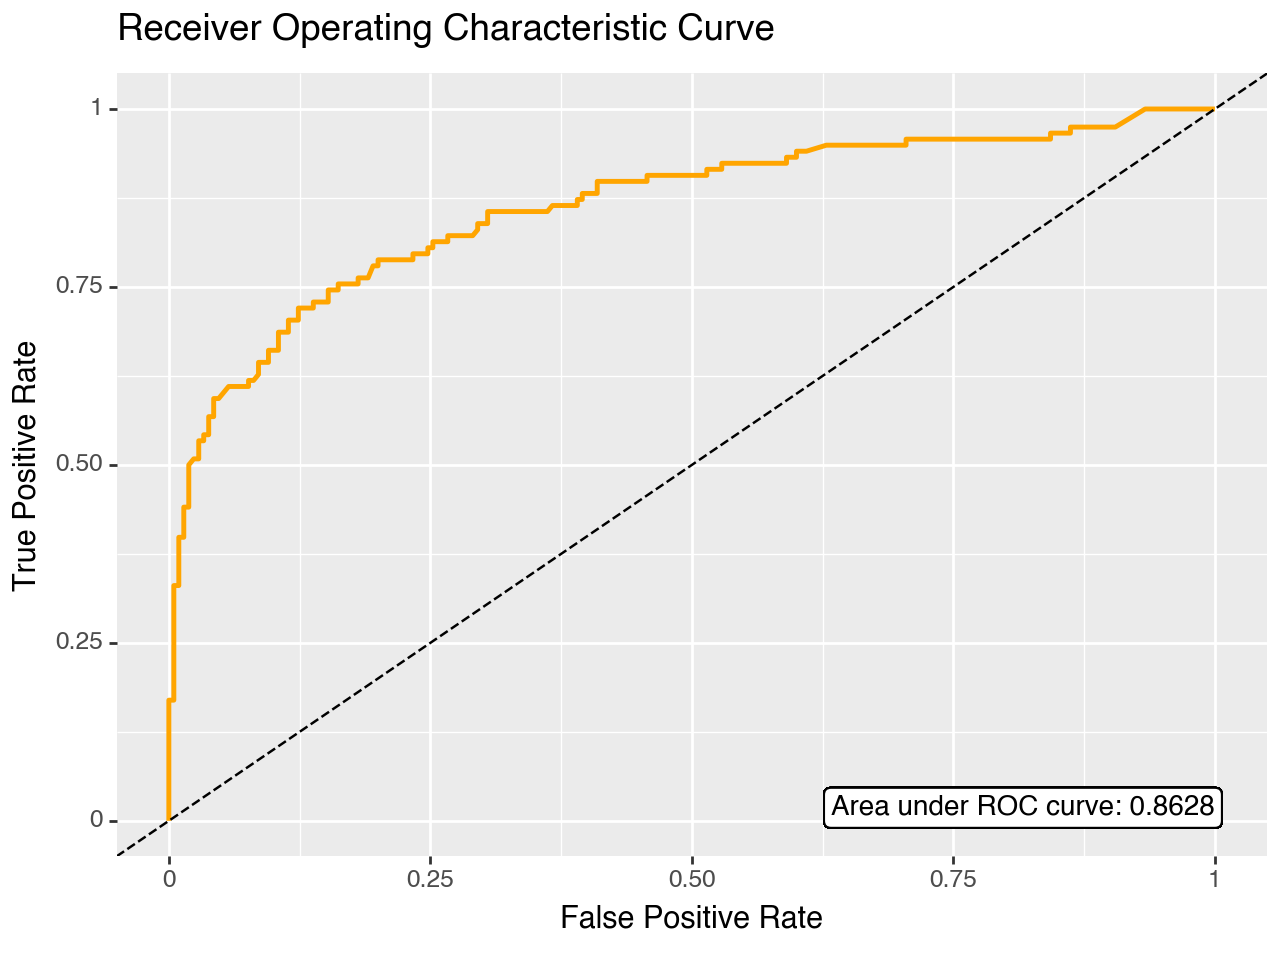

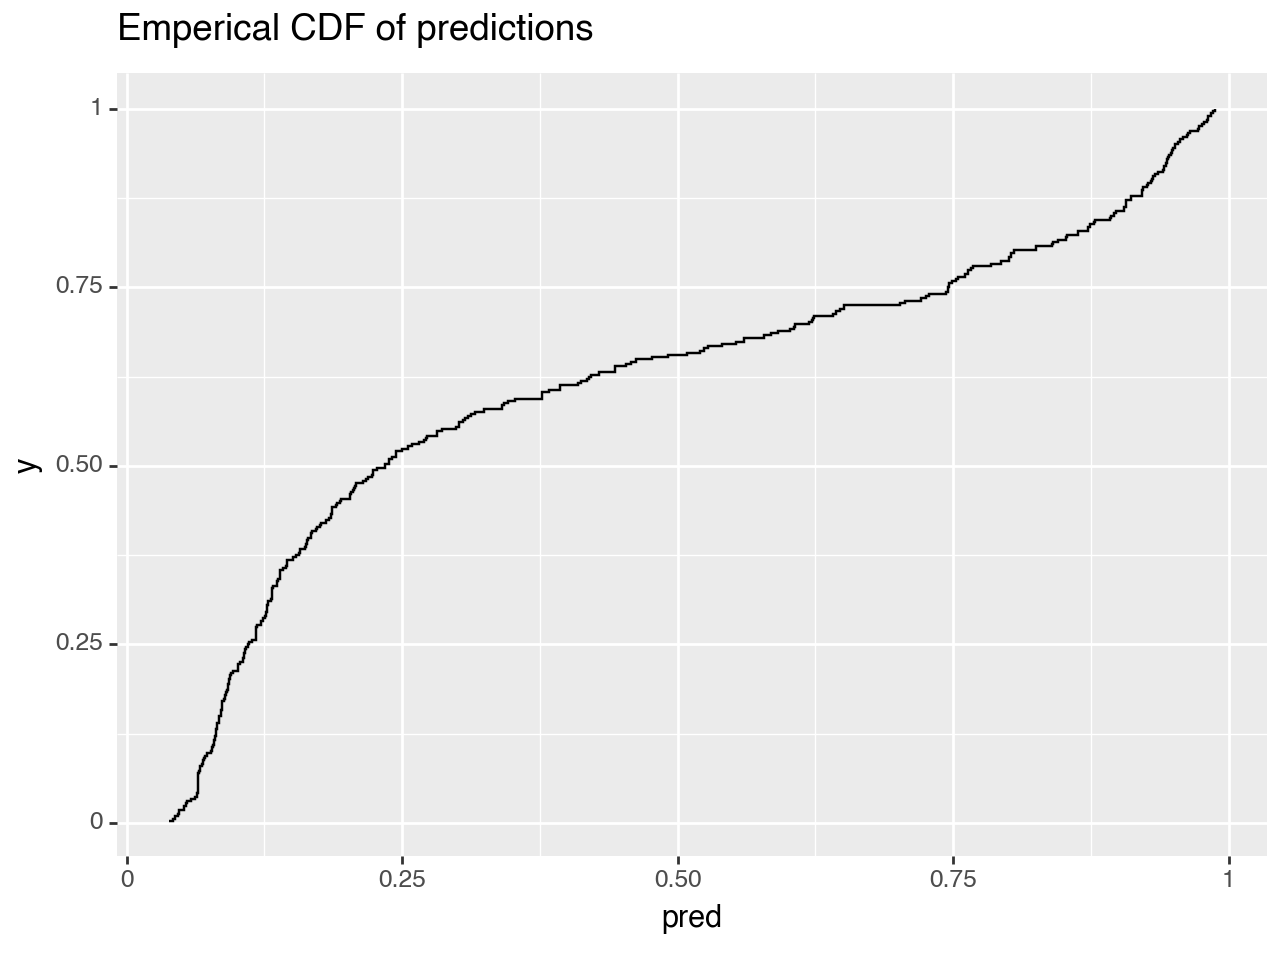

[<Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>]

In [23]:
plots[:3]

## Using GridsearchCV

In [24]:
# from scipy.stats import loguniform

# rng = np.random.RandomState(1234)

# grid_size = 3
# grid_learning_rate = loguniform.rvs(0.1, 1.0, size = grid_size)
# grid_gamma = rng.uniform(low = 0, high = 1, size = grid_size)
# grid_max_depth = list(range(4, 10))
# grid_min_child_weight = rng.randint(3, 50, grid_size)
# grid_subsample = rng.uniform(0.01, 0.9, size=grid_size)
# grid_colsample_bytree = rng.uniform(0.1, 0.9, grid_size)
# grid_reg_lambda = loguniform.rvs(1e-9, 1000, size = grid_size)
# grid_reg_alpha = loguniform.rvs(1, 100, size=grid_size)
# grid_n_estimators = rng.randint(50, 1000, size=grid_size)


In [25]:
# %%time 

# from sklearn.model_selection import GridSearchCV

# param = {
#     'clf__learning_rate': grid_learning_rate,
#     'clf__gamma': grid_gamma,
#     'clf__max_depth': grid_max_depth,
#     'clf__min_child_weight': grid_min_child_weight,
#     'clf__subsample': grid_subsample,
#     'clf__colsample_bytree': grid_colsample_bytree,
#     'clf__reg_lambda': grid_reg_lambda,
#     'clf__reg_alpha': grid_reg_alpha,
#     'clf__n_estimators': grid_n_estimators
# }

# gridsearch = GridSearchCV(pipe, param_grid=param, cv=skf, n_jobs=-1, scoring='roc_auc', return_train_score=True)
# gridsearch.fit(X_train_full, y_train_full)
# print('Best score of Grid Search:', gridsearch.best_score_)

In [26]:
# pipe['clf']

In [27]:
# print("Best parameter (CV score=%0.3f):" % gridsearch.best_score_)
# print(gridsearch.best_params_)

# Feature importances

### How do we get feature names?

In [28]:
pipe.feature_names_in_
pipe.named_steps['encode_cats'].get_feature_names_out()
pipe.named_steps['imputer'].feature_names_in_

array(['scale__pass_through_numerics__age',
       'scale__pass_through_numerics__fare',
       'remainder__encoder__pclass_1', 'remainder__encoder__pclass_2',
       'remainder__encoder__pclass_3', 'remainder__encoder__sex_female',
       'remainder__encoder__sex_male', 'remainder__encoder__embarked_C',
       'remainder__encoder__embarked_Q', 'remainder__encoder__embarked_S',
       'remainder__encoder__embarked_nan', 'remainder__encoder__deck_A',
       'remainder__encoder__deck_B', 'remainder__encoder__deck_C',
       'remainder__encoder__deck_D', 'remainder__encoder__deck_E',
       'remainder__encoder__deck_FG', 'remainder__encoder__deck_M',
       'remainder__encoder__title_Master',
       'remainder__encoder__title_Miss', 'remainder__encoder__title_Mr',
       'remainder__encoder__title_Mrs', 'remainder__encoder__title_Noble',
       'remainder__pass_through_numerics__sibsp',
       'remainder__pass_through_numerics__parch'], dtype=object)

### Base XGBoost feature importance 1

In [29]:
dict_importances = {
    'name': pipe.named_steps['imputer'].get_feature_names_out(),
    #this gets the gain importance get_fscore returns weight type
    'importance': pipe.named_steps['clf'].feature_importances_
}

df_importances = pd.DataFrame(dict_importances)

print(df_importances.sort_values('importance', ascending=False).head())

                               name  importance
5    remainder__encoder__sex_female    0.346254
20     remainder__encoder__title_Mr    0.136823
4      remainder__encoder__pclass_3    0.122463
22  remainder__encoder__title_Noble    0.060655
2      remainder__encoder__pclass_1    0.050644


### Base XGBoost feature importance 2

Explanation: The train() API's method get_score() is defined as:

`get_score(fmap='', importance_type='weight')`

fmap (str (optional)) – The name of feature map file.
importance_type
1. ‘weight’ - the number of times a feature is used to split the data across all trees.
1. ‘gain’ - the average gain across all splits the feature is used in.
1. ‘cover’ - the average coverage across all splits the feature is used in.
1. ‘total_gain’ - the total gain across all splits the feature is used in.
1. ‘total_cover’ - the total coverage across all splits the feature is used in.

<Axes: >

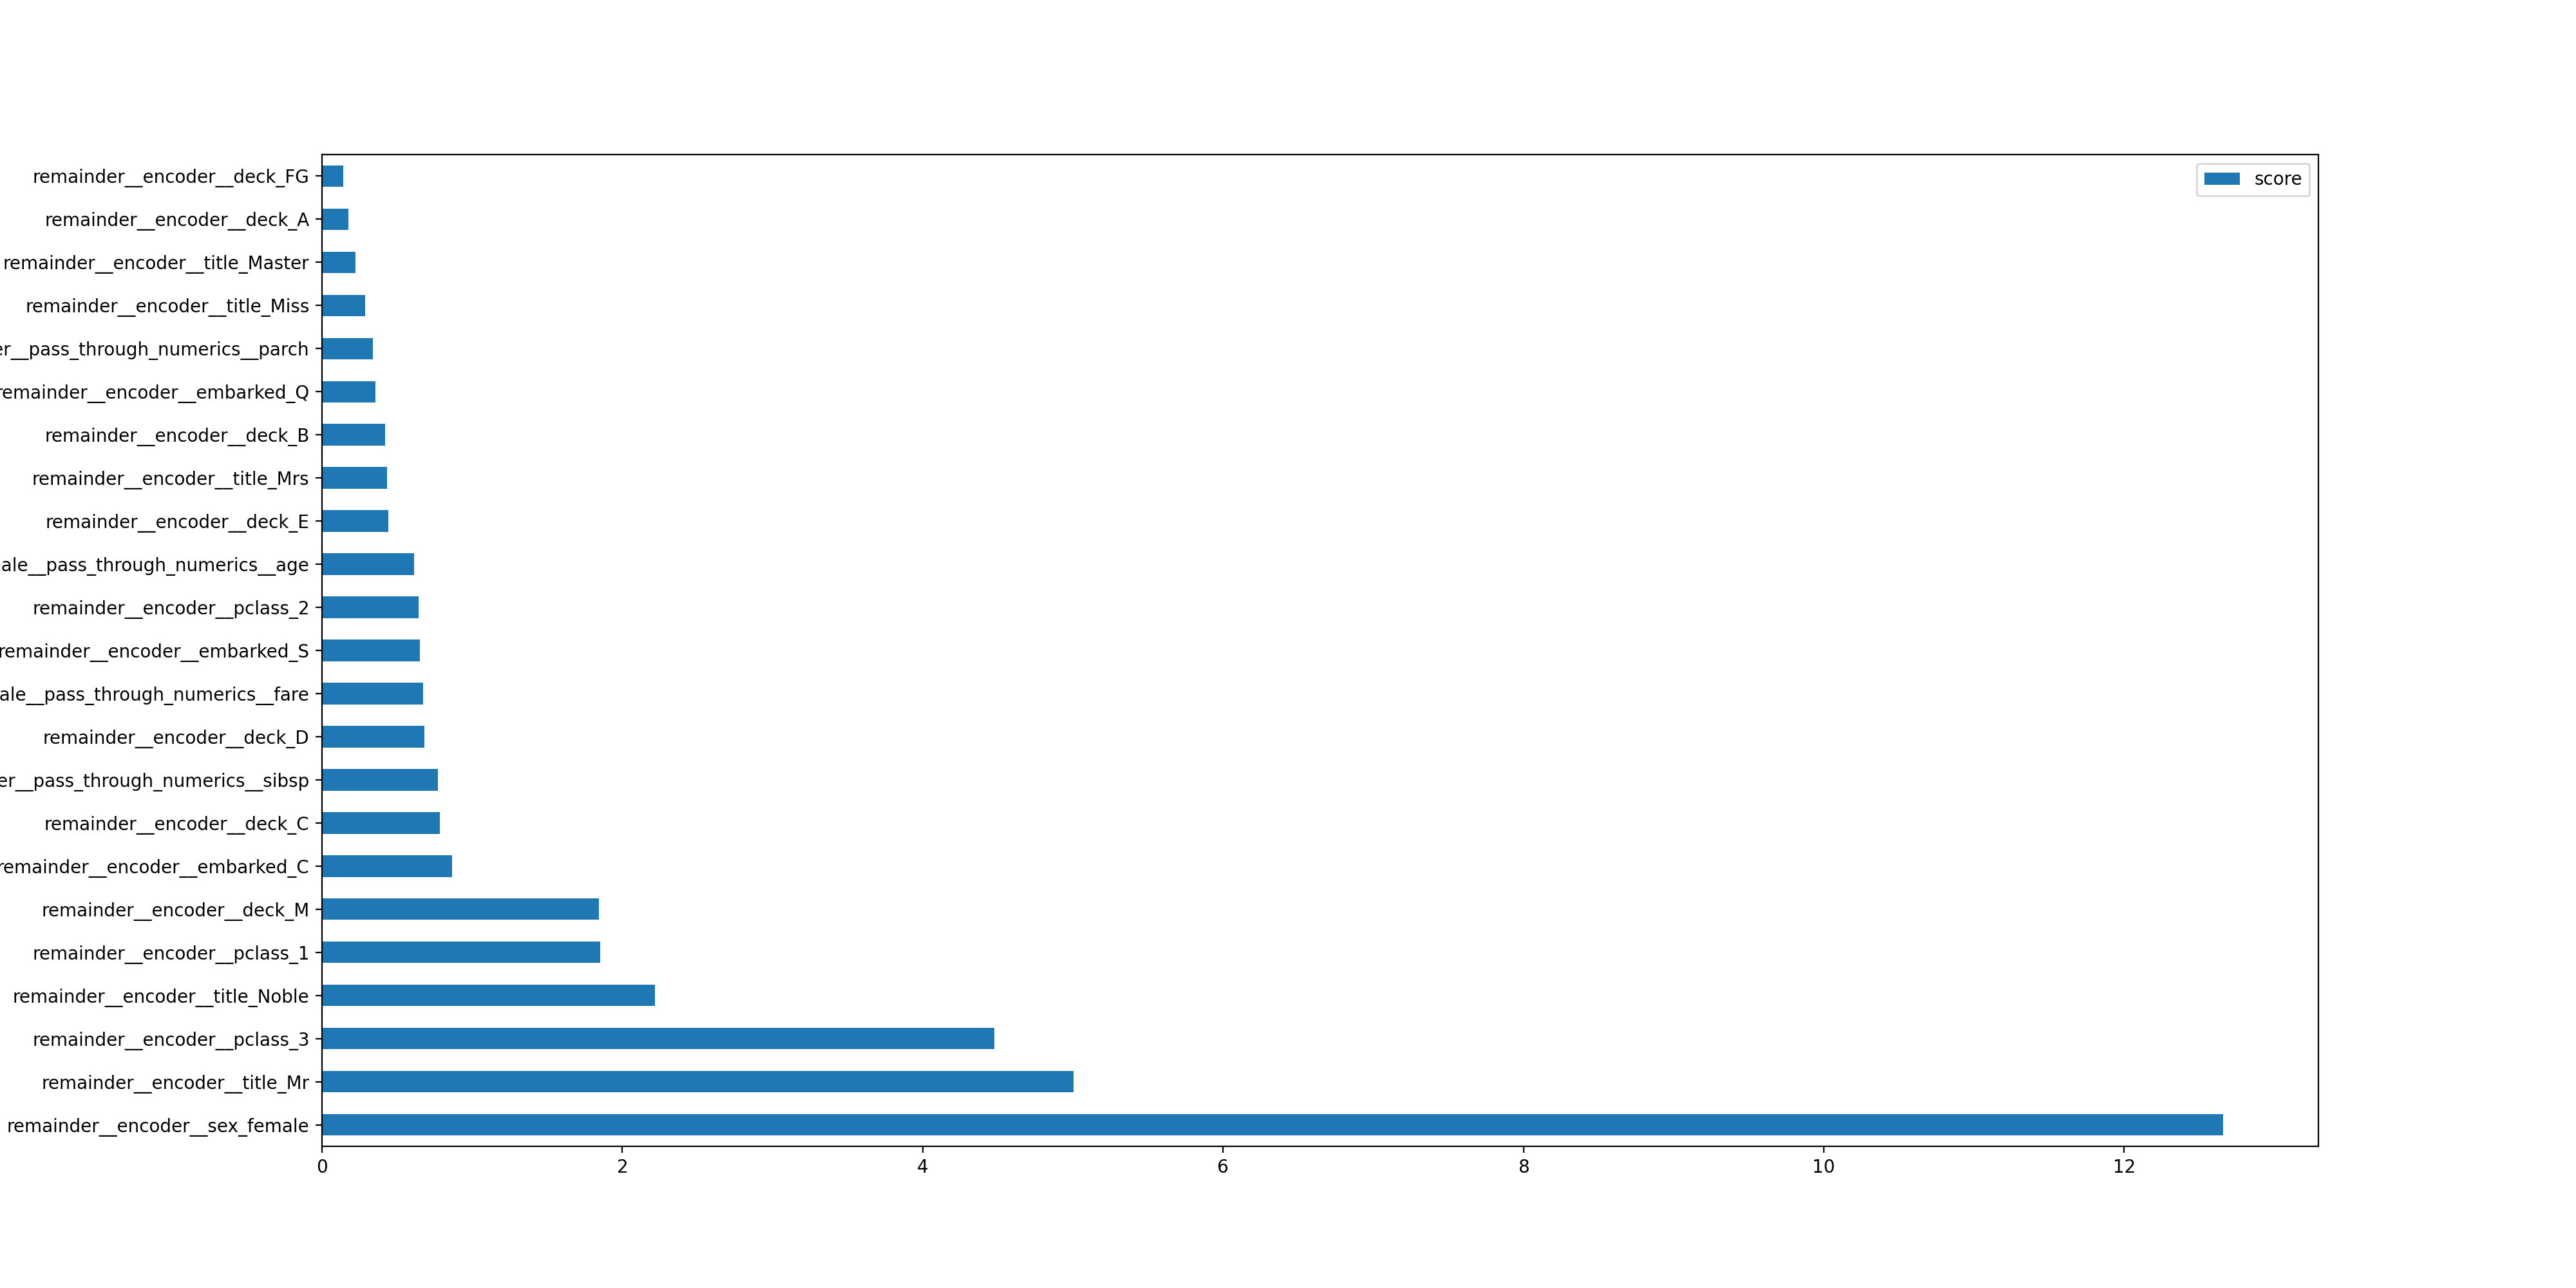

In [30]:
feature_important = pipe.named_steps['clf'].get_booster().get_score(importance_type='gain')

keys = list(feature_important.keys())
values = list(feature_important.values())

data_importance = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_importance.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [31]:
feature_important

{'scale__pass_through_numerics__age': 0.6135244965553284,
 'scale__pass_through_numerics__fare': 0.674299955368042,
 'remainder__encoder__pclass_1': 1.8516839742660522,
 'remainder__encoder__pclass_2': 0.6424079537391663,
 'remainder__encoder__pclass_3': 4.477546691894531,
 'remainder__encoder__sex_female': 12.659942626953125,
 'remainder__encoder__embarked_C': 0.8682999610900879,
 'remainder__encoder__embarked_Q': 0.3566286265850067,
 'remainder__encoder__embarked_S': 0.6504038572311401,
 'remainder__encoder__deck_A': 0.1755884438753128,
 'remainder__encoder__deck_B': 0.42214855551719666,
 'remainder__encoder__deck_C': 0.7859472632408142,
 'remainder__encoder__deck_D': 0.6825776100158691,
 'remainder__encoder__deck_E': 0.44312241673469543,
 'remainder__encoder__deck_FG': 0.1432574838399887,
 'remainder__encoder__deck_M': 1.8451342582702637,
 'remainder__encoder__title_Master': 0.22128567099571228,
 'remainder__encoder__title_Miss': 0.2859382629394531,
 'remainder__encoder__title_Mr': 

### Permutation based importance

The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature.

In [32]:
def run_pipeline(pipeline, input, steps):
    """Run an sklearn pipeline down named steps. Returns the output dataframe

    Args:
        pipeline (sklearn pipeline): The pipeline you want to run
        input (pandas dataframe): The input dataframe
        steps (list[str]): the steps you want to run the pipeline down
    """

    for step in steps:
        output = pipeline[step].transform(input)
        input = output

    return(output)

#run_pipeline(pipe, X_test, ['encode_cats', 'scale', 'imputer'])


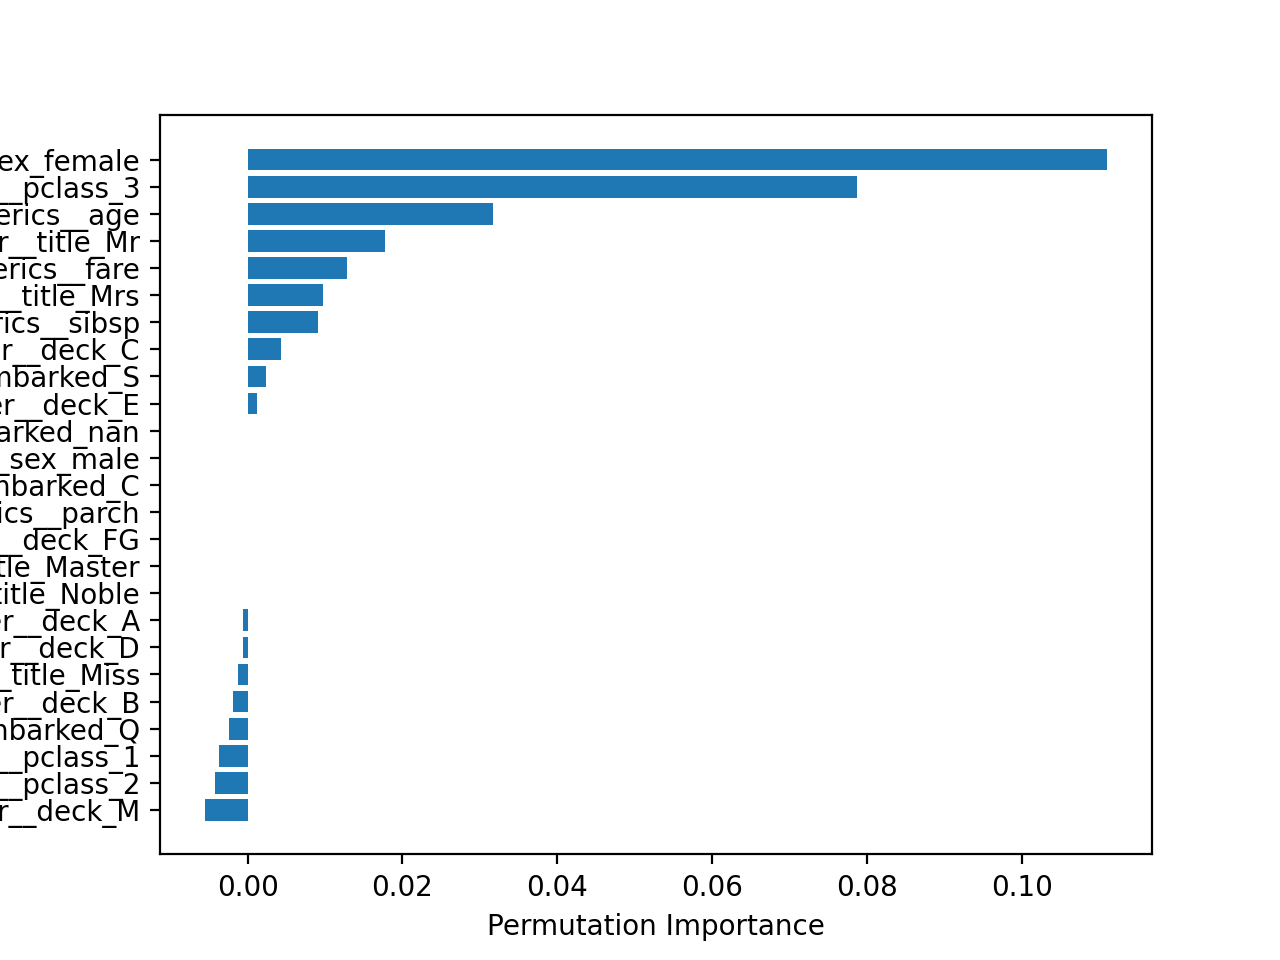

In [33]:
from sklearn.inspection import permutation_importance

plt.figure().clear()
X_preprocessed = run_pipeline(pipe, X_test, ['encode_cats', 'scale', 'imputer'])
perm_importance = permutation_importance(pipe['clf'], X_preprocessed, y_test)
sorted_idx = perm_importance.importances_mean.argsort()

plt.barh(X_preprocessed.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

### Shapley value based importance

In [34]:
# import shap

# explainer = shap.TreeExplainer(pipe['clf'])
# shap_values = explainer.shap_values(X_preprocessed)
# shap.summary_plot(shap_values, input, plot_type="bar")

# Appendix: Annoying times working with sklearn OneHotEncoder

In [35]:
# from sklearn.preprocessing import OneHotEncoder

# enc = OneHotEncoder()
# X = X[['Sex', 'Pclass', 'Embarked']].copy()
# enc.fit_transform(X).toarray()

In [36]:
# enc.get_feature_names_out()

In [37]:
# cat_features = ['Pclass', 'Sex', 'Embarked']
# encoded_features = []
# dfs = [X]

# for df in dfs:
#     for feature in cat_features:
#         encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
#         n = df[feature].nunique()
#         cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
#         encoded_df = pd.XFrame(encoded_feat, columns=cols)
#         encoded_df.index = df.index
#         encoded_features.append(encoded_df)


In [38]:
# cols 

In [39]:
# encoded_feat